<a href="https://colab.research.google.com/github/PogusTheWhisper/42-bAnGkOk-rush/blob/main/code/EasyImageClassify/fifaclassify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
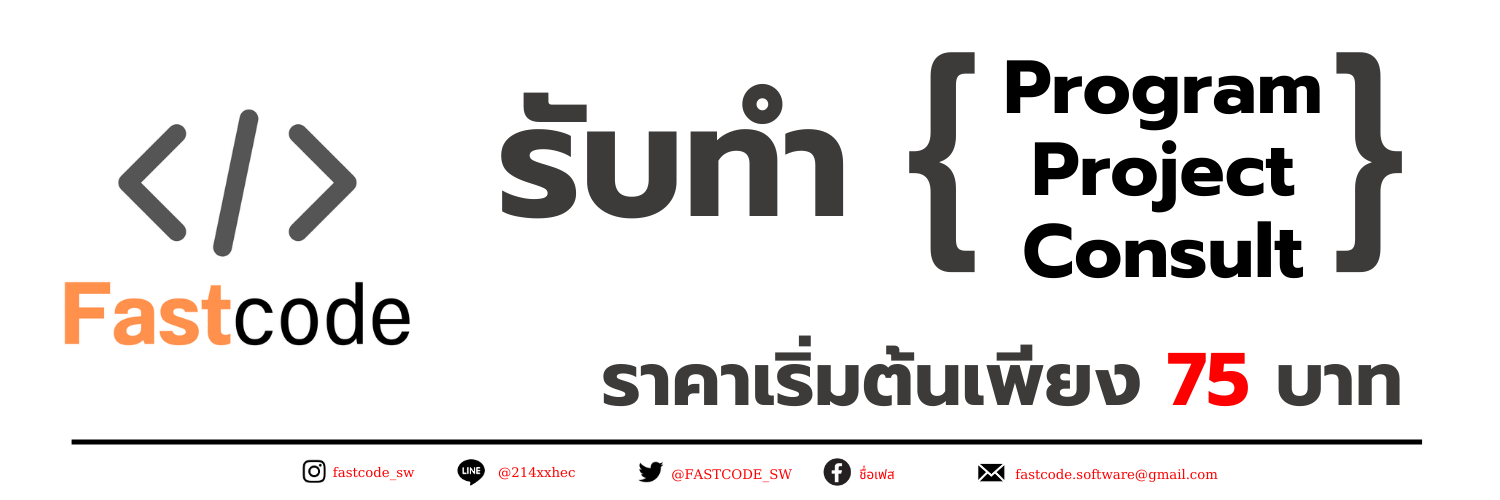

# 🚀 FASTCODE HACK & LEARN
🎯 **ฝากกดติดตาม Tiktok, IG ด้วยนะครับ**

- 🎵 **Tiktok:** [@fastcode.software](https://www.tiktok.com/@fastcode.software)  
- 📸 **Instagram:** [@fastcode_sw](https://www.instagram.com/fastcode_sw)

---

## 💻 FASTCODE | รับจ้างเขียนโค้ด - โปรเจ็ค - ปรึกษางาน/งานแข่ง

- 📞 **Line ID:** `@214xxhec`  
- 🌐 **Website:** [https://fastcodesoftware.github.io](https://fastcodesoftware.github.io/fastcode_landing_page/)

---


## Setup

In [ ]:
# Download dataset and unzip

!wget -q -c -O dataset.zip https://github.com/FastcodeSoftware/Fastcode-Hack-And-Learn/raw/refs/heads/main/code/EasyImageClassify/dataset.zip
!unzip -o -q /content/dataset.zip -d dataset

In [ ]:
!rm -rf /content/sample_data

In [ ]:
# Install necessary libraries

!pip install -q face_recognition numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 455.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 29.3 MB/s eta 0:00:00


In [ ]:
# Restart runtime

exit()

## Preprocess

In [ ]:
# Prepare dataset

import face_recognition
import cv2
import os
from tqdm import tqdm
import shutil
import numpy as np

def resize_with_padding(image, target_size=224):
    h, w = image.shape[:2]
    scale = target_size / max(h, w)
    resized = cv2.resize(image, (int(w * scale), int(h * scale)))

    h_pad = target_size - resized.shape[0]
    w_pad = target_size - resized.shape[1]

    top = h_pad // 2
    bottom = h_pad - top
    left = w_pad // 2
    right = w_pad - left

    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded

def clean_dataset_faces(input_root, output_root):
    if os.path.exists(output_root):
        shutil.rmtree(output_root)
    os.makedirs(output_root, exist_ok=True)

    for split in ['train', 'valid']:
        input_split = os.path.join(input_root, split)
        output_split = os.path.join(output_root, split)

        if not os.path.exists(input_split):
            continue

        for class_name in os.listdir(input_split):
            class_input_path = os.path.join(input_split, class_name)
            class_output_path = os.path.join(output_split, class_name)
            os.makedirs(class_output_path, exist_ok=True)

            for img_name in tqdm(os.listdir(class_input_path), desc=f"{split}/{class_name}"):
                if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue

                img_path = os.path.join(class_input_path, img_name)
                image = face_recognition.load_image_file(img_path)

                # Convert once to BGR for OpenCV operations
                image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                if class_name == 'fifa':
                    face_locations = face_recognition.face_locations(image)
                    if face_locations:
                        top, right, bottom, left = face_locations[0]
                        face_image = image[top:bottom, left:right]
                        face_image_bgr = cv2.cvtColor(face_image, cv2.COLOR_RGB2BGR)
                        resized_face = resize_with_padding(face_image_bgr, 224)
                        save_image = resized_face
                    else:
                        # Fallback to padding whole image
                        save_image = resize_with_padding(image_bgr, 224)
                else:
                    save_image = resize_with_padding(image_bgr, 224)

                save_path = os.path.join(class_output_path, img_name)
                cv2.imwrite(save_path, save_image)

clean_dataset_faces("dataset", "cleaned_dataset")

valid/fifa: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]


## Load dataset

In [ ]:
# Import necessary libraries

from fastai.vision.all import *

In [ ]:
path = Path('cleaned_dataset')

In [ ]:
path.ls()

(#2) [Path('cleaned_dataset/train'),Path('cleaned_dataset/valid')]

In [ ]:
from pathlib import Path

path = Path('cleaned_dataset')

for split in ['train', 'valid']:
    print(f"\nChecking {split}:")
    for folder in (path/split).iterdir():
        if folder.is_dir():
            img_files = list(folder.glob('*'))
            print(f"  {folder.name}: {len(img_files)} files")



Checking train:
  buff: 10 files
  fifa: 10 files

Checking valid:
  buff: 1 files
  fifa: 1 files


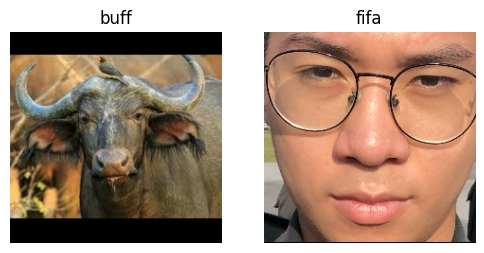

In [ ]:
# Create DataLoaders using filenames and a labeling function, resizing each image to 224x224

dls = ImageDataLoaders.from_folder(
    path,
    train='train',
    valid='valid',
    item_tfms=Resize(224),
    bs=2,  # small enough to fit into the valid set
    fail_fast=False
)

dls.show_batch()


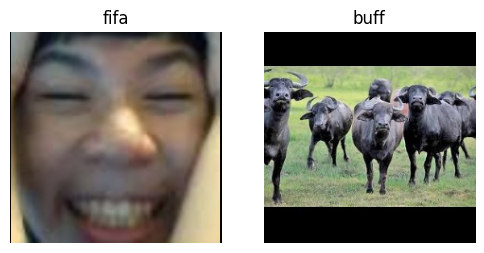

In [ ]:
# Display a batch of images

dls.show_batch()

## Train

In [ ]:
# Create a vision learner using the ResNet34 architecture and track accuracy as the evaluation metric

learn = vision_learner(dls, resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 96.0MB/s]


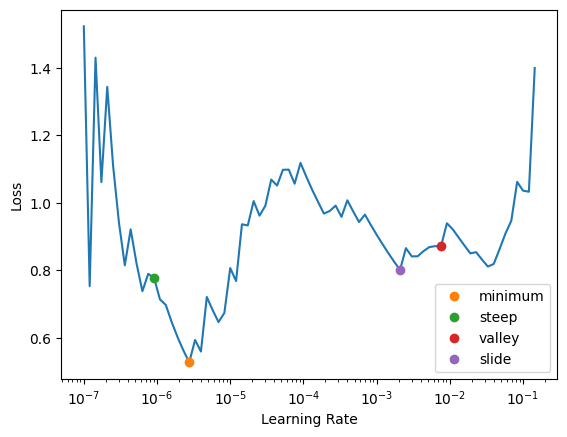

In [ ]:
# Find optimal learning rate
lr = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
# Fine-tune the pre-trained model for 1 epoch on the current dataset

learn.fine_tune(1, lr.valley)

epoch,train_loss,valid_loss,accuracy,time
0,0.750555,4.161271,0.500000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.389352,0.060026,1.000000,00:00


## Evaluate

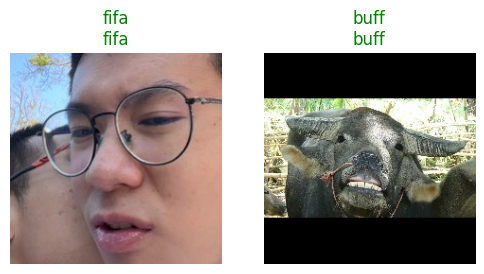

In [ ]:
learn.show_results()